## MNIST CNN

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

### Data

In [3]:
path = untar_data(URLs.MNIST)

In [4]:
path.ls()

[WindowsPath('C:/Users/kting/.fastai/data/mnist_png/testing'),
 WindowsPath('C:/Users/kting/.fastai/data/mnist_png/training')]

In [5]:
il = ImageList.from_folder(path, convert_mode='L') # Convert_moded is some PIL stuff

In [6]:
il.items[0]

WindowsPath('C:/Users/kting/.fastai/data/mnist_png/testing/0/10.png')

In [7]:
defaults.cmap='binary' # colour map, it's a matplotlib thing

In [8]:
il

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: C:\Users\kting\.fastai\data\mnist_png

(1, 28, 28) because it's one colour channel, 28x28 size. Recall that the order of axes is such that it always specify the no. of channels before the height and width.

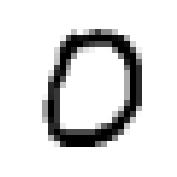

In [9]:
il[0].show()

You have to split the `ItemList` by training and validation set. You would almost always want a validation set btw. But if for some reason you don't want that, you still have to specify `.no_split()` method. You must specify the splitting mechanism.

In [11]:
sd = il.split_by_folder(train='training', valid='testing')

In [12]:
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: C:\Users\kting\.fastai\data\mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: C:\Users\kting\.fastai\data\mnist_png;

Test: None

In [13]:
(path/'training').ls()

[WindowsPath('C:/Users/kting/.fastai/data/mnist_png/training/0'),
 WindowsPath('C:/Users/kting/.fastai/data/mnist_png/training/1'),
 WindowsPath('C:/Users/kting/.fastai/data/mnist_png/training/2'),
 WindowsPath('C:/Users/kting/.fastai/data/mnist_png/training/3'),
 WindowsPath('C:/Users/kting/.fastai/data/mnist_png/training/4'),
 WindowsPath('C:/Users/kting/.fastai/data/mnist_png/training/5'),
 WindowsPath('C:/Users/kting/.fastai/data/mnist_png/training/6'),
 WindowsPath('C:/Users/kting/.fastai/data/mnist_png/training/7'),
 WindowsPath('C:/Users/kting/.fastai/data/mnist_png/training/8'),
 WindowsPath('C:/Users/kting/.fastai/data/mnist_png/training/9')]

In [14]:
ll = sd.label_from_folder()

In [15]:
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
0,0,0,0,0
Path: C:\Users\kting\.fastai\data\mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
0,0,0,0,0
Path: C:\Users\kting\.fastai\data\mnist_png;

Test: None

In [16]:
x,y = ll.train[0]

0 torch.Size([1, 28, 28])


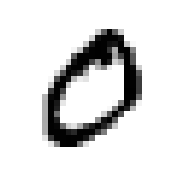

In [17]:
x.show()
print(y,x.shape)

In [18]:
# Not going to use get_transforms because we are dealing with small, digit images.
# The random padding function returns two transforms; 
# the bit that does the padding and the bit that does the random crop. 
# So you have to use star(*) to say put both these transforms in this list.
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], []) # Empty array at the right is the trfms for the validation set - none.

In [19]:
ll = ll.transform(tfms)

In [20]:
bs = 128

In [21]:
# not using imagenet_stats because not using pretrained model
data = ll.databunch(bs=bs).normalize()

In [22]:
x,y = data.train_ds[0]

0


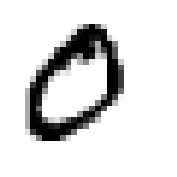

In [23]:
x.show()
print(y)

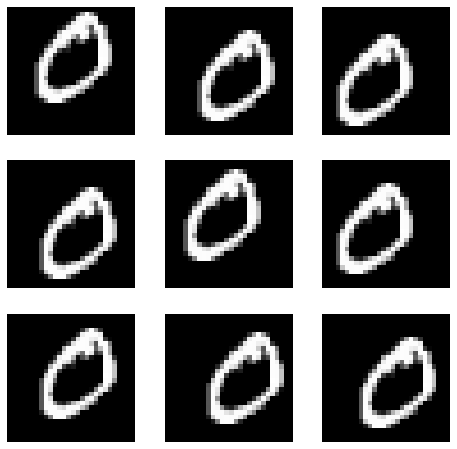

In [24]:
def _plot(i,j,ax): 
    data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8)) # plot_multi is from fastai

For an image, how many different transformed versions does it make given a set of transformations? Well, as many as you like. Each time you obtain an image from the DataBunch `data`, the transformation loaded inside will be recalled. So, because of random padding (in the transformation) the extent of padding varies from version to version, of the same origin image.

In [26]:
xb,yb = data.one_batch() # obtain a batch, of size bs = 128
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

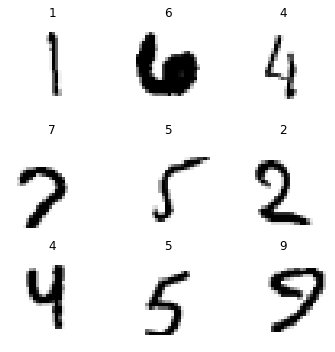

In [27]:
data.show_batch(rows=3, figsize=(5,5))

## Basic CNN with batchnorm

In [28]:
# Create a convolution layer. We'll fix the kernel size, stride and padding.
def conv(ni,nf): 
    return nn.Conv2d(ni, nf, 
                     kernel_size=3, 
                     stride=2, # Stride of 2 means the output image's height and width is halved from the input.
                     padding=1)

In [29]:
model = nn.Sequential(
    # ---------------  # Input:  (1, 28, 28)
    conv(1, 8),        # Input channel: 1, Output channel 8. Output: (8, 14, 14). Recall each conv() halves.
    nn.BatchNorm2d(8), # Output: (8, 14, 14)
    nn.ReLU(),         # Output: (8, 14, 14)
    conv(8, 16),       # Output: (16, 7, 7)
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32),      # Output: (32, 4, 4). Stride 2 conv over 7 is math.ceil(7/2) = 4.
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16),      # Output: (16, 2, 2)
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10),      # Output: (10, 1, 1)
    nn.BatchNorm2d(10),
    Flatten()          # remove (1,1) grid, to get Output: (10). 10 classes for 10 digits. Flatten() is referred to as Lambda.
)

In [30]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [31]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
___________________________________________________

In [32]:
xb = xb.cuda() # xb is the 128 training examples (x) in the batch (b). Loads this batch into GPU.

In [33]:
model(xb).shape

# You can call the model as if it's a function with the argument being the training batch. And output will be the predictions.
# The shape of the predictions being [128, 10] makes sense.

torch.Size([128, 10])

In [34]:
learn.lr_find(end_lr=100)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


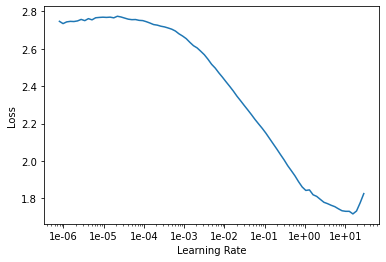

In [35]:
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.222646,0.327511,0.898400,02:00
1,0.130357,0.106709,0.964800,01:50
2,0.066614,0.037889,0.988300,01:55


### Refactor

Rather than saying conv, batch norm, ReLU all the time, fast.ai already has something called `conv_layer` which lets you create conv, batch norm, ReLU combinations.

So:
- `nn.Conv2d` is just the convolution layer.
- `conv_layer` is a group of layers: `Conv2d`, `ReLU`, and `BatchNorm2d`.

In [44]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

In [45]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [39]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [49]:
learn.model
#learn.summary()

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): Sequential(
    (0): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), paddin

In [40]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.240178,0.147749,0.953000,01:56
1,0.188905,0.240603,0.926500,01:50
2,0.173800,0.292819,0.913500,01:50
3,0.140974,0.098274,0.968700,01:58
4,0.129942,0.101046,0.967600,01:55
5,0.098192,0.058117,0.981500,01:49
6,0.093047,0.070270,0.978900,01:46
7,0.068394,0.038765,0.987600,01:47
8,0.049732,0.030739,0.989400,01:43
9,0.044091,0.029585,0.990400,01:44


### Resnet-ish

The inspiration of how resblocks was conceived is interesting.

Like how a 20-layer neural network is outperforming a 56-layer neural network, on the _training loss_, which is astounding because a 56-layer nn has more parameters and thus should be able to overfit over the training dataset, if anything. This is _training loss_ we are not talking about, not validation loss. But yet, mysteriously, it doesn't.

So the researcher, he attempted to reconstruct the 56-layer neural network such that its performance (on training loss) will be _at least_ equal to that of the unmodified 20-layer variant. But how would you do that?

So the first 20 layers in this new network is the same as the 20-layer model. The remaining 36-layer is substituted with 18 resblocks of 2 layer each. You have to go find the image online, but if you recall, each resblock has the following expression relating the input, the 2 conv layers, and the output:

- `output = x + Conv2((Conv1(input))`

Note that the `Conv` in the expression above is the convolutional layer, plus the ReLU, plus the batchnorm.

So, this 'plus x' in the above expression (`x + something`), means something called a skip connection is introduced. A resblock's output could be exactly the same as the input, if the 2 conv layers inside have all 0s in its parameter matrices. 

So, this newly created resnet, which is configured by 20 ordinary conv layers followed by 18 resblocks, could not possibly underperform compared to the original 20-layer neural network. Because, if for some reason adding more conv layers to a model objectively wrecks its ability to fit better, then in such a situation the resnet setup would simply set all the parameters in _all resblocks_ to 0, and thus is identical to the original 20-layer neural network. In this scenario, the input will simply just take the skip-connection-path, skipping all the 36 convolutions till the output. 

Ultimately, the end result is that the guy won ImageNet that year. His ResNet has been revolutionary.

#### DenseNet, and DenseBlocks

Note that when initialising a resblock, if you set `dense=True`, you create a denseblock. By default, `dense` is set to `False`.

DenseBlocks are the same as resblocks, with one difference. Is that the output of the denseblock is such that the original input is concatenated with the output of the 2 `conv_layer()`. So, resblock is an element-wise addition, but for denseblock, there's a concatenation, and thus as such there's a new dimension being added along a new dimension. As to how the shape works out, or examples, it's not really covered. So sorry.

Chains of denseblocks will increase the number of these output layers, and thus they can be memory intensive.

Jeremy - So for dealing with small datasets, you should definitely experiment with dense blocks and DenseNets. They tend to work really well on small datasets.

Also, because it's possible to keep those original input pixels all the way down the path, they work really well for segmentation. Because for segmentation, you want to be able to reconstruct the original resolution of your picture, so having all of those original pixels still there is a super helpful.

In [41]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [43]:
# fast.ai already has res_block implemented

help(res_block)

Help on function res_block in module fastai.layers:

res_block(nf, dense:bool=False, norm_type:Union[fastai.layers.NormType, NoneType]=<NormType.Batch: 1>, bottle:bool=False, **conv_kwargs)
    Resnet block of `nf` features. `conv_kwargs` are passed to `conv_layer`.



In [51]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [52]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

The above is the same as the following:
```python
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)
```

Recall `conv2` is a helper function that we created (not fast.ai), which is based off from this fast.ai function `conv_layer()`.

In [53]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [54]:
learn.model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): SequentialEx(
      (layers): ModuleList(
        (0): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): ReLU(inplace=True)
          (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): ReLU(inplace=True)
          (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (2): MergeLayer()
      )
    )
  )
  (1): Sequential(
    (0): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    

This is the configuration of the resblock. Notice that it is made up of 2 `conv_layer()` blocks.
```python
(1): SequentialEx(
      (layers): ModuleList(
        (0): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): ReLU(inplace=True)
          (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): ReLU(inplace=True)
          (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (2): MergeLayer()
      )
    )
```

`SequentialEx` is fast.ai's Sequential Extended block. It's like a normal sequential block, but it stores the input as `x.orig` (see the docs for `MergeLayer()`), where `MergeLayer()` will then do a `x + x.orig`.

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


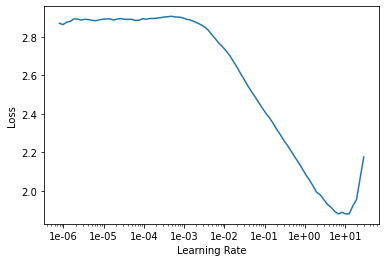

In [55]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [56]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.196935,0.123444,0.964700,02:12
1,0.131828,0.120856,0.962500,01:58
2,0.115479,0.126104,0.960500,02:02
3,0.091889,0.106830,0.966100,02:00
4,0.075817,0.046759,0.984800,01:53
5,0.067011,0.044336,0.985100,01:58
6,0.050361,0.038760,0.989000,01:57
7,0.040744,0.037752,0.987500,01:56
8,0.036091,0.021126,0.993300,01:56
9,0.026445,0.016401,0.994800,01:55


So, accuracy is 99.5%. Which was the cutting edge at the time of 2015.

In [57]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
___________________________________________________

## fin